In [159]:
from importlib import reload
import visa_helper as vs
import time
import joblib
from pylab import *
from tqdm import tqdm

reload(vs)


<module 'visa_helper' from 'C:\\Users\\mathusla\\Documents\\MATHUSLA\\JupyterNotebooks\\Keysight\\visa_helper.py'>

# Step 1: connect to the scope
- If you don't know the address, do vs.connect()
- Otherwise, put the address in the argument will speed it up

In [2]:
scope = vs.connect(address = "TCPIP0::10.0.0.4::inst0::INSTR", timeout=30_000) # set 30 second

Connected to VISA [TCPIP0::10.0.0.4::inst0::INSTR]:  KEYSIGHT TECHNOLOGIES,EXR054A,MY63160110,11.50.00201



# Example 1: read the current waveform from the scope

- For simplicity of the code and better readout speed, please configure the trigger threshold and channel setup on the scope

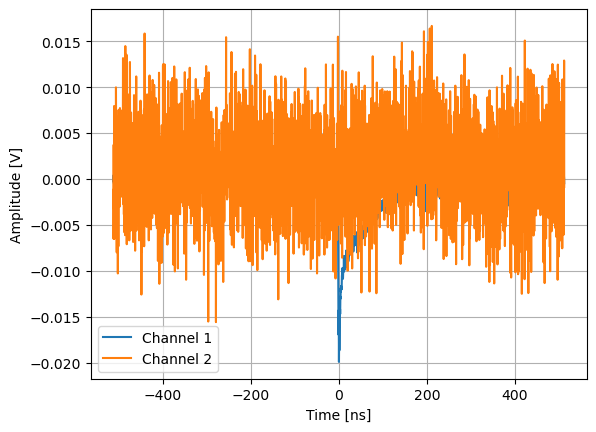

In [19]:
trigger_channel = 1
read_channel = [1,2]
acquire_length = 4096

data,time_series=vs.read_waveform(scope, trigger_channel = trigger_channel, read_channel = read_channel, acquire_length = acquire_length, calibrate = True, initialize = True, calibration_data=None)

for ch in data:
    plot(time_series*1e9, data[ch], label=f"Channel {ch}")

# xlim(-10,10)
xlabel("Time [ns]")
ylabel("Amplitude [V]")
legend()
grid()

# Example 2: repetitively read multiple waveforms from the scope

- For simplicity of the code and better readout speed, please configure the trigger threshold and channel setup on the scope

20/100 events acquired, time elapsed 0.9 s, time from last print 0.9 s
40/100 events acquired, time elapsed 1.5 s, time from last print 0.7 s
60/100 events acquired, time elapsed 2.3 s, time from last print 0.7 s
80/100 events acquired, time elapsed 3.0 s, time from last print 0.8 s
100/100 events acquired, time elapsed 3.8 s, time from last print 0.7 s


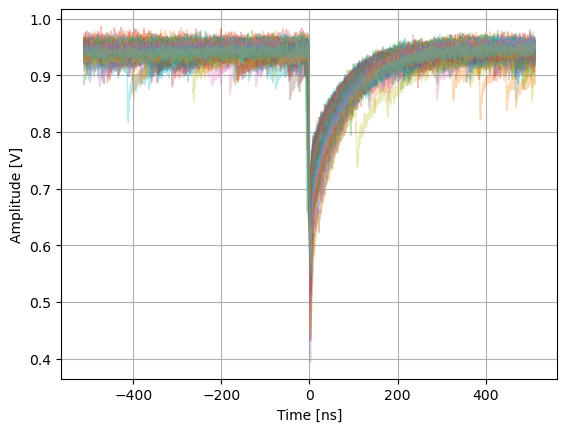

In [20]:
data_save = vs.get_events(scope, Nevents = 100, print_every_n = 20, trigger_channel = trigger_channel, read_channel = read_channel, acquire_length = acquire_length, calibrate = True)
time_series = data_save["metadata"]["time_series"]*1e9

for i in range(len(data_save[1])):
    plot(time_series, data_save[1][i],alpha=0.3, linewidth=1)

# xlim(-10,10)
xlabel("Time [ns]")
ylabel("Amplitude [V]")
grid()

# Acquire the data

In [200]:
data_save = vs.get_events(scope, Nevents = 2000, print_every_n = 200, trigger_channel = trigger_channel, read_channel = read_channel, acquire_length = acquire_length, calibrate = True)
# joblib.dump(data_save, "muon_coinc_ch1_ch2.joblib",compress =False)
time_series = data_save["metadata"]["time_series"]*1e9

200/2000 events acquired, time elapsed 174.0 s, time from last print 174.0 s
400/2000 events acquired, time elapsed 342.9 s, time from last print 168.9 s
600/2000 events acquired, time elapsed 515.8 s, time from last print 172.9 s
800/2000 events acquired, time elapsed 692.0 s, time from last print 176.2 s
1000/2000 events acquired, time elapsed 867.0 s, time from last print 175.0 s
1200/2000 events acquired, time elapsed 1042.6 s, time from last print 175.5 s
1400/2000 events acquired, time elapsed 1218.7 s, time from last print 176.2 s
1600/2000 events acquired, time elapsed 1396.4 s, time from last print 177.6 s
1800/2000 events acquired, time elapsed 1572.7 s, time from last print 176.3 s
2000/2000 events acquired, time elapsed 1742.5 s, time from last print 169.8 s


['muon_coinc_ch1_ch2.joblib']

In [28]:
data_save = vs.get_events(scope, Nevents = 2000, print_every_n = 200, trigger_channel = trigger_channel, read_channel = read_channel, acquire_length = acquire_length, calibrate = True)
joblib.dump(data_save, "waveform_scintillator.joblib",compress =False)
time_series = data_save["metadata"]["time_series"]*1e9

200/2000 events acquired, time elapsed 100.7 s, time from last print 100.7 s
400/2000 events acquired, time elapsed 207.5 s, time from last print 106.7 s
600/2000 events acquired, time elapsed 315.7 s, time from last print 108.2 s
800/2000 events acquired, time elapsed 421.3 s, time from last print 105.7 s
1000/2000 events acquired, time elapsed 519.9 s, time from last print 98.6 s
1200/2000 events acquired, time elapsed 622.2 s, time from last print 102.3 s
1400/2000 events acquired, time elapsed 726.9 s, time from last print 104.7 s
1600/2000 events acquired, time elapsed 832.6 s, time from last print 105.6 s
1800/2000 events acquired, time elapsed 936.0 s, time from last print 103.4 s
2000/2000 events acquired, time elapsed 1041.6 s, time from last print 105.6 s


# Analysis 1: Coinicidence time resolution

In [94]:
data_save=joblib.load("muon_coinc_ch1_ch2.joblib")
time_series = data_save["metadata"]["time_series"]*1e9

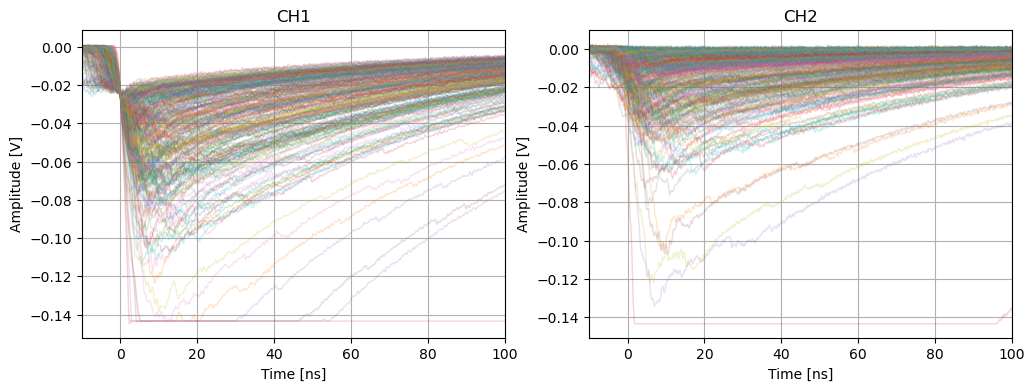

In [107]:
# for i in range(len(data_save[1])):
fig,axs = subplots(1,2,figsize=(12,4))

for iax in [0,1]:
    sca(axs[iax])
    for i in range(300):
        plot(time_series, data_save[iax+1][i],alpha=0.2, linewidth=1)
        title(f"CH{iax+1}")

    xlim(-10,100)
    xlabel("Time [ns]")
    ylabel("Amplitude [V]")
    grid()



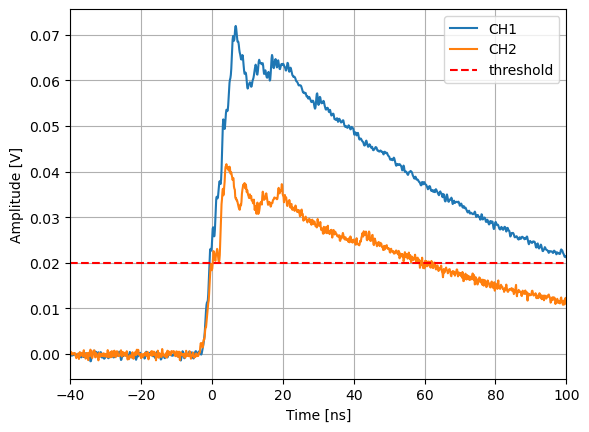

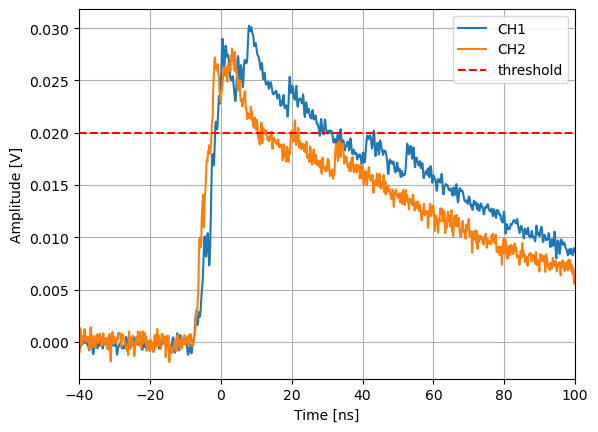

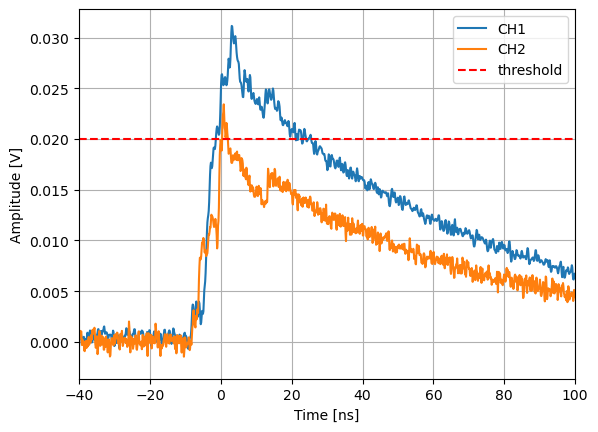

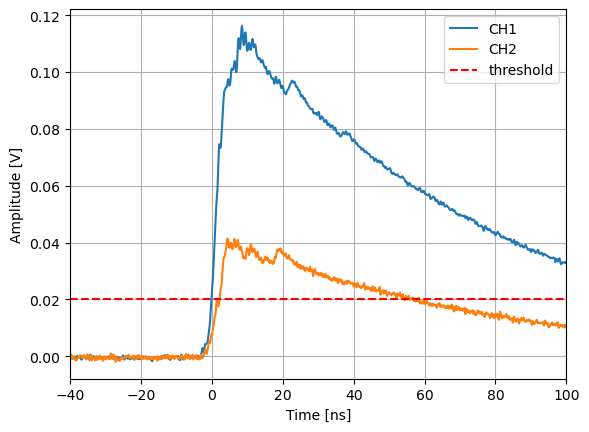

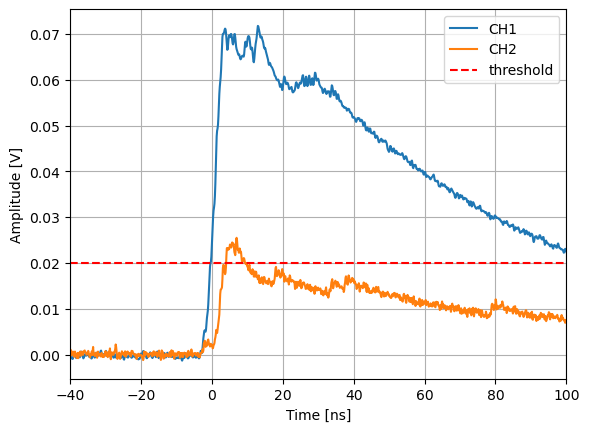

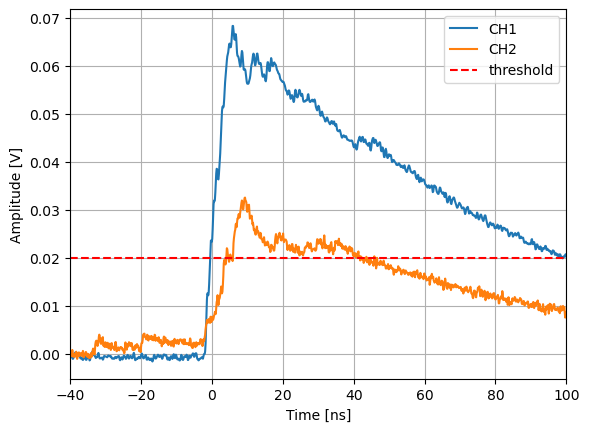

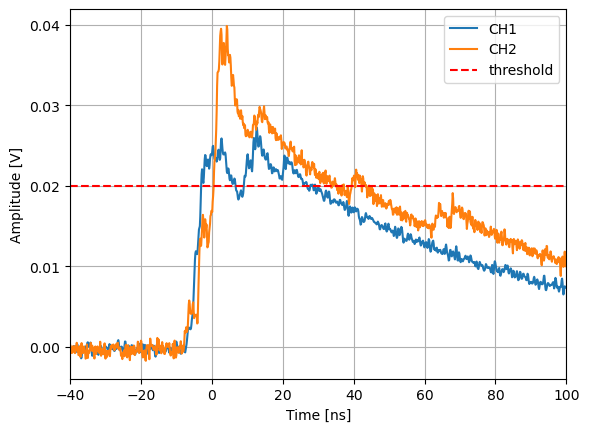

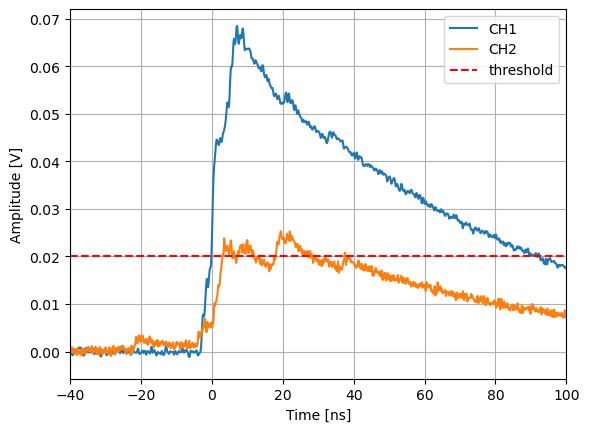

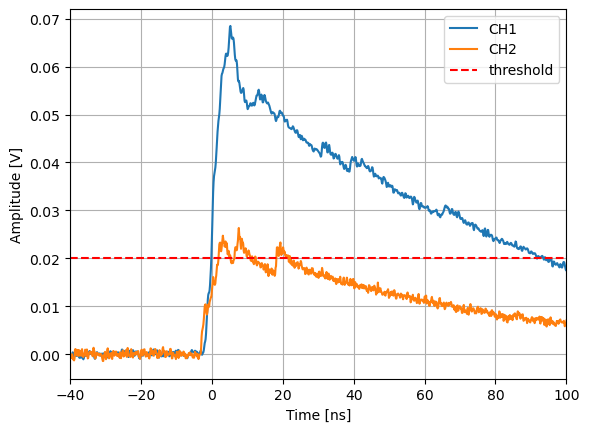

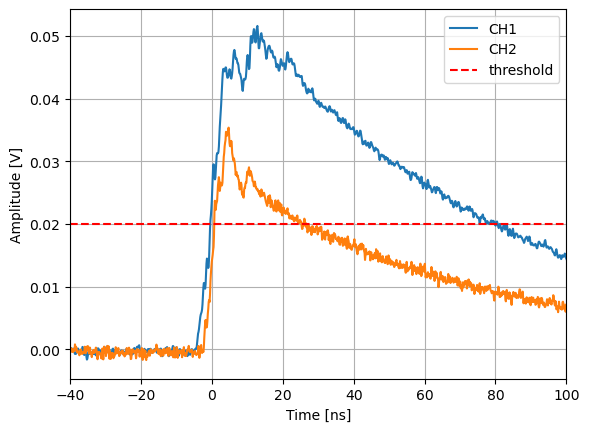

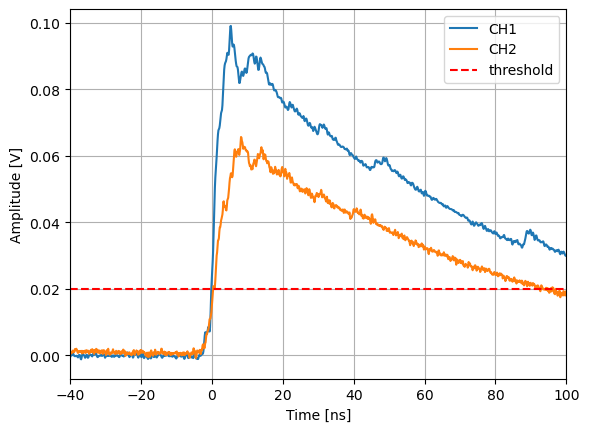

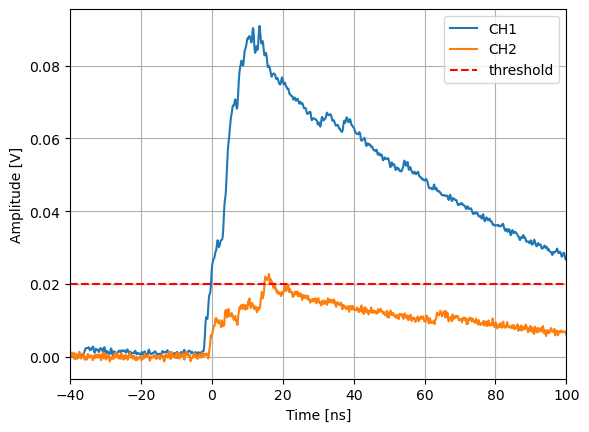

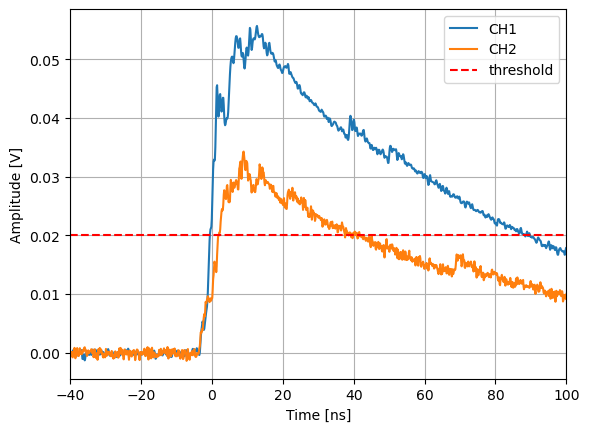

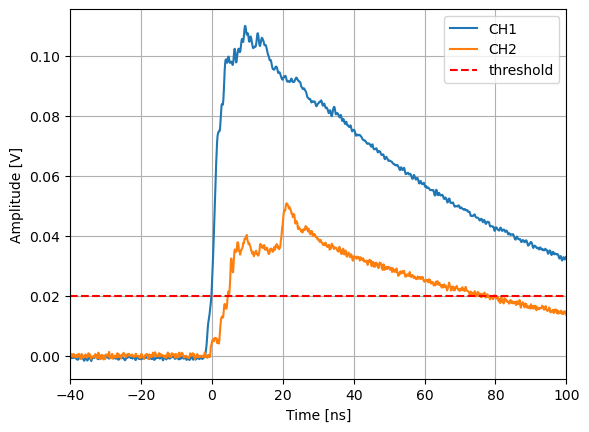

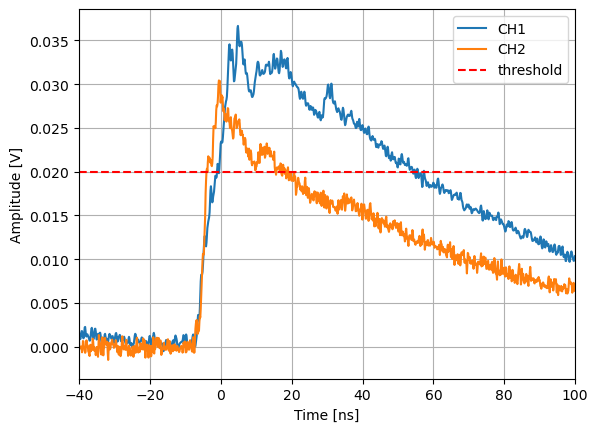

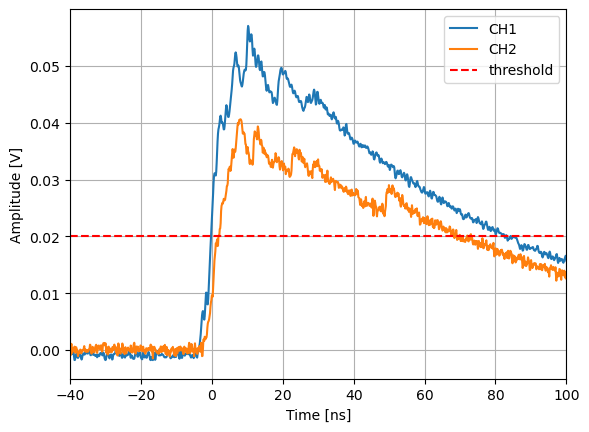

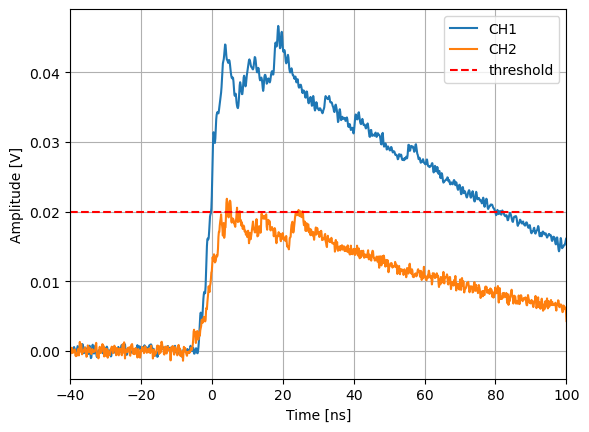

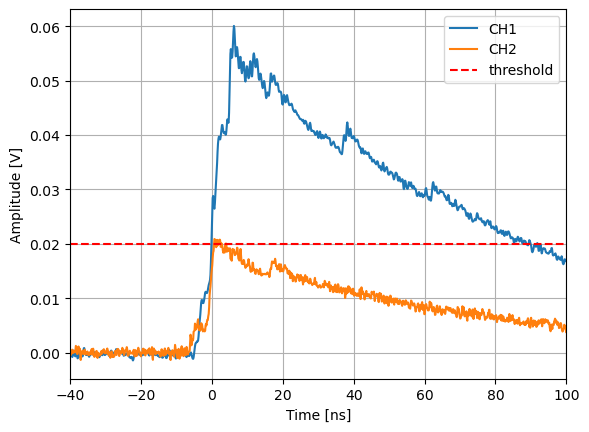

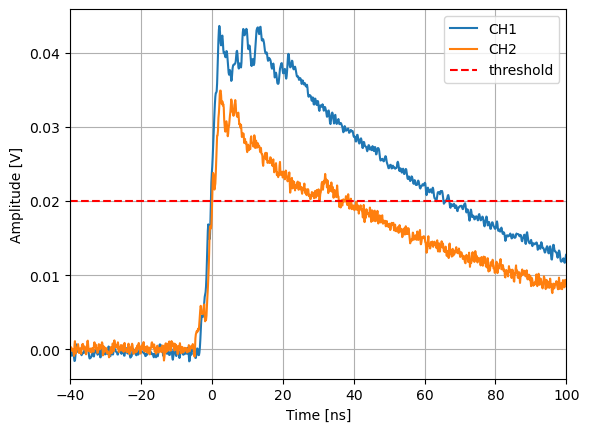

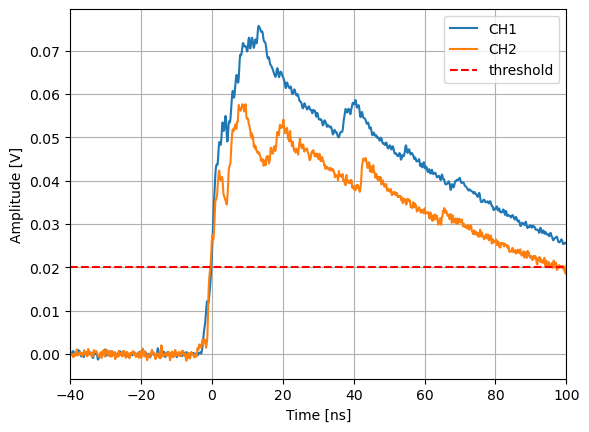

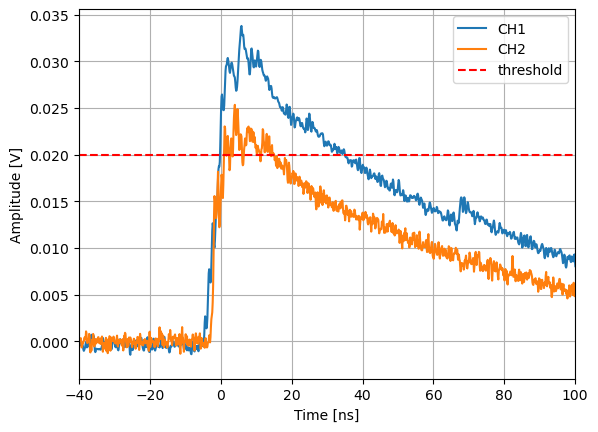

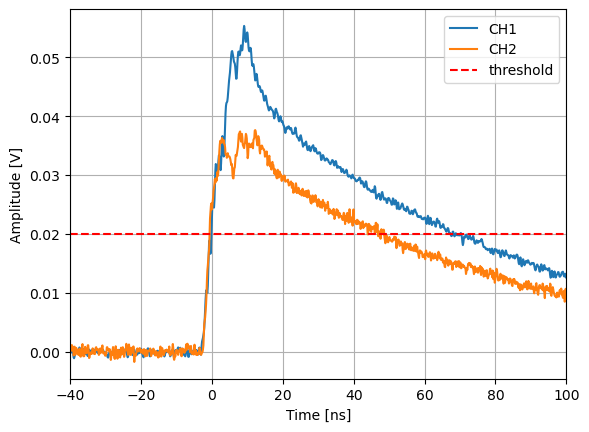

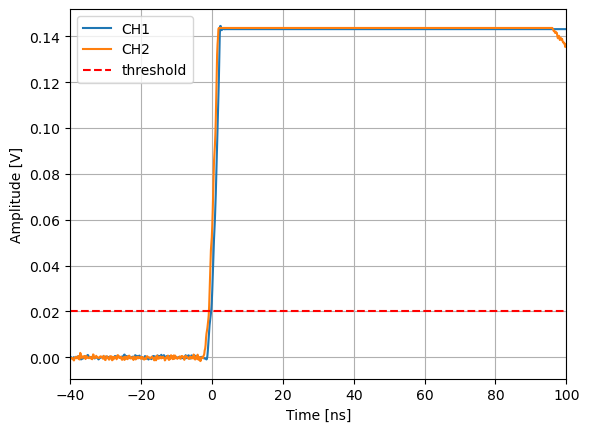

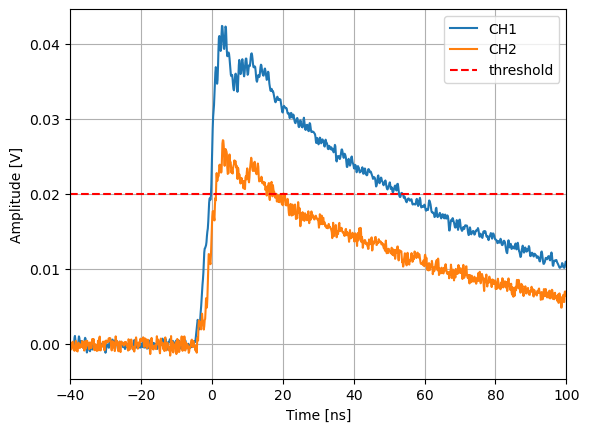

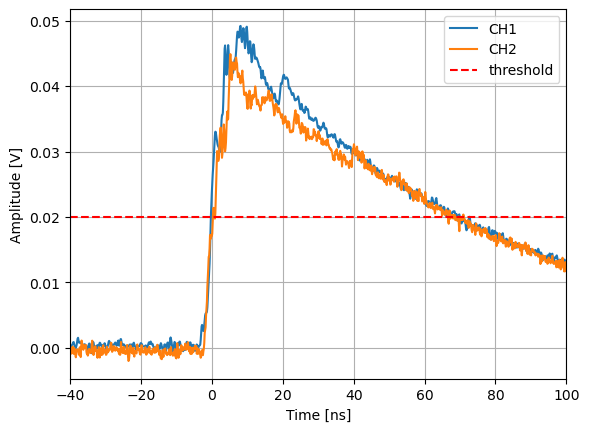

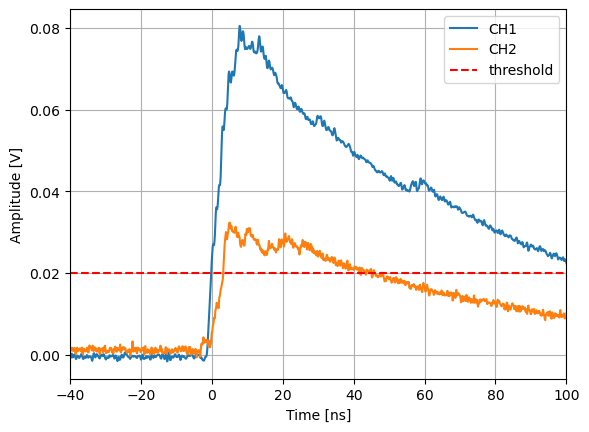

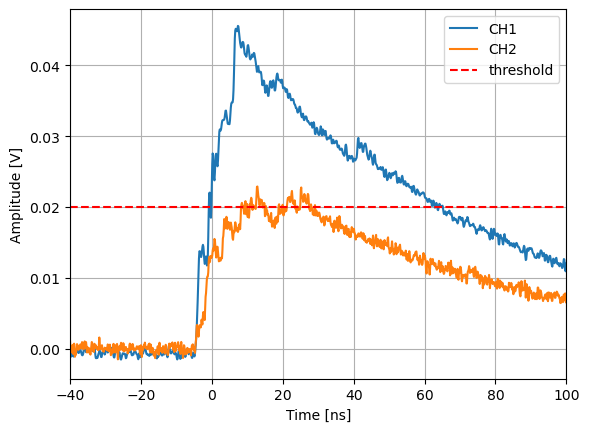

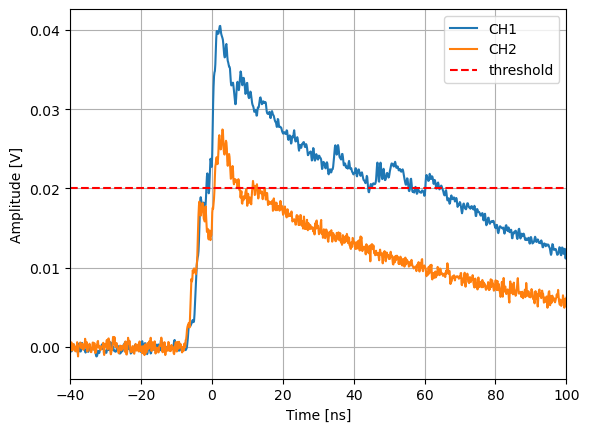

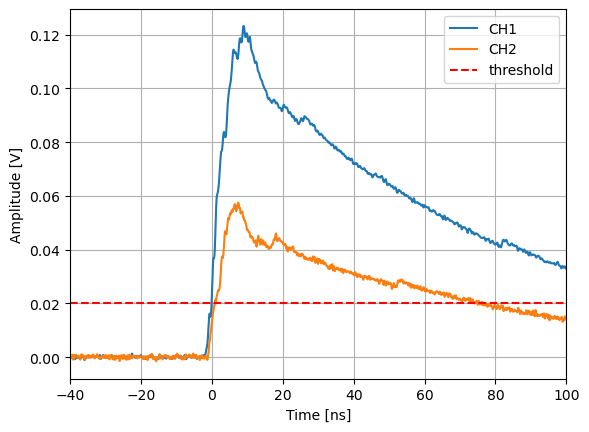

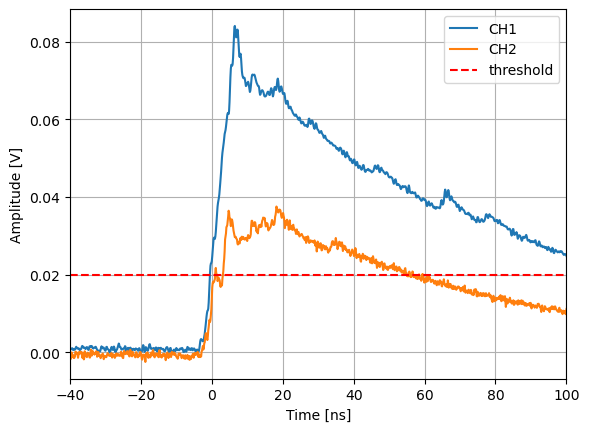

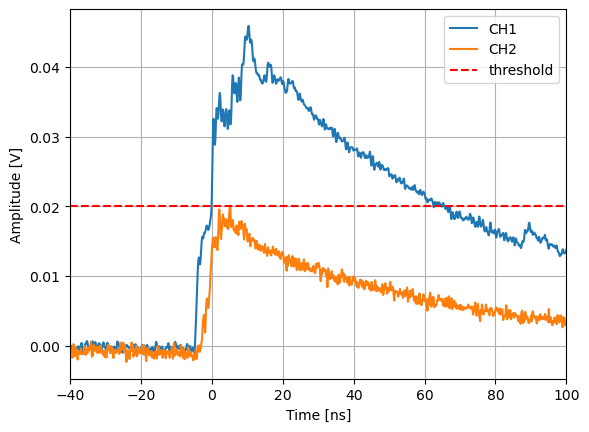

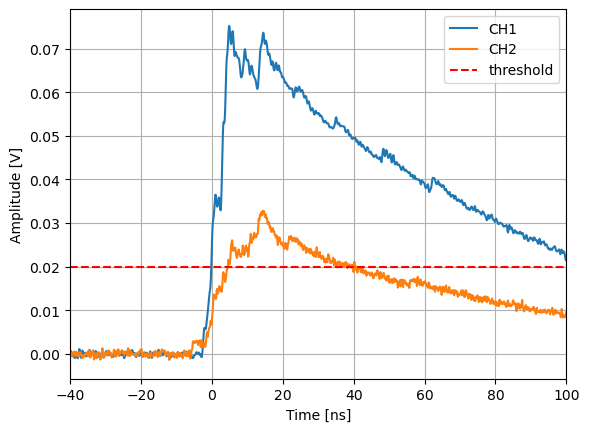

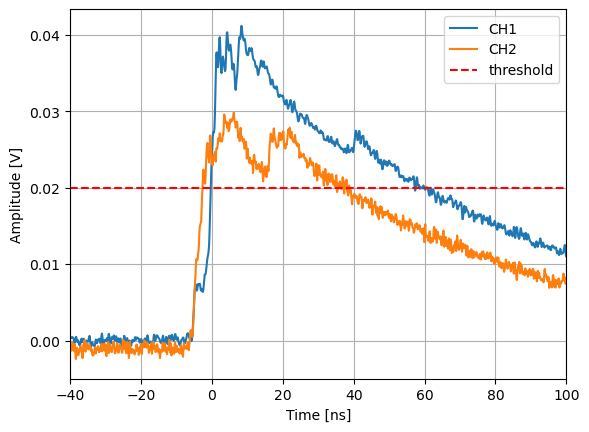

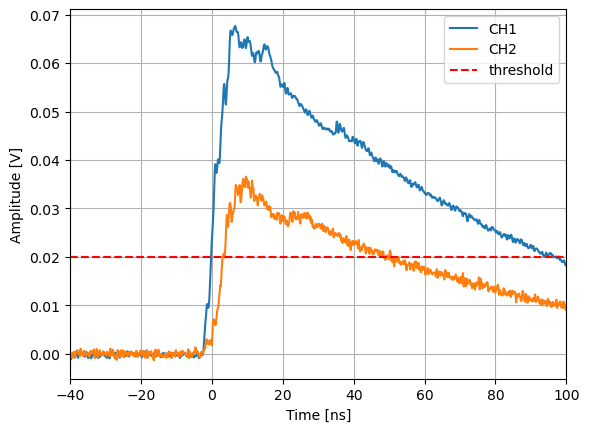

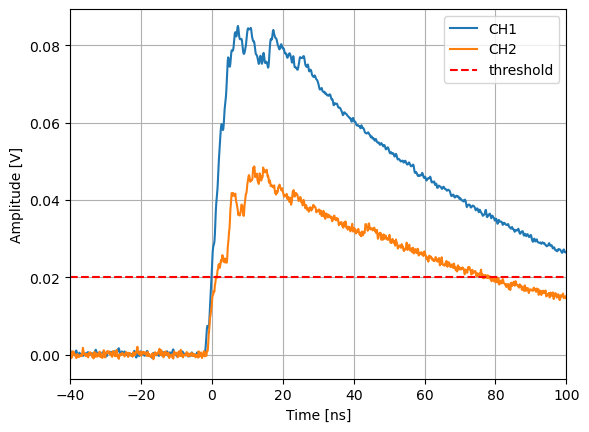

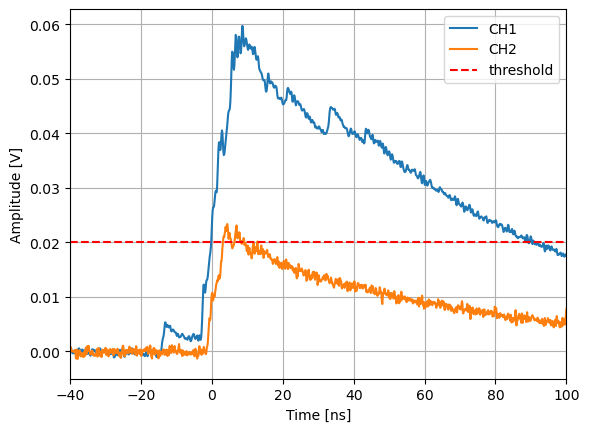

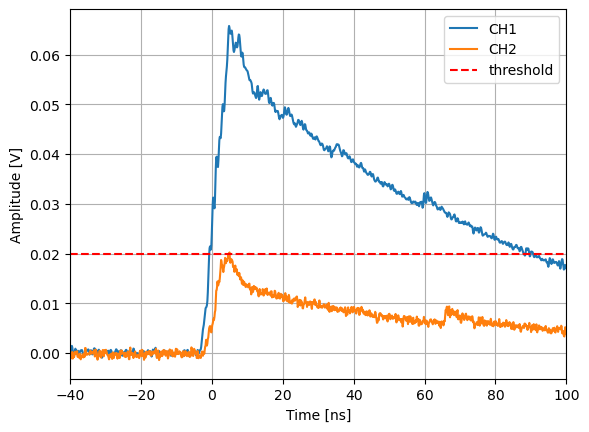

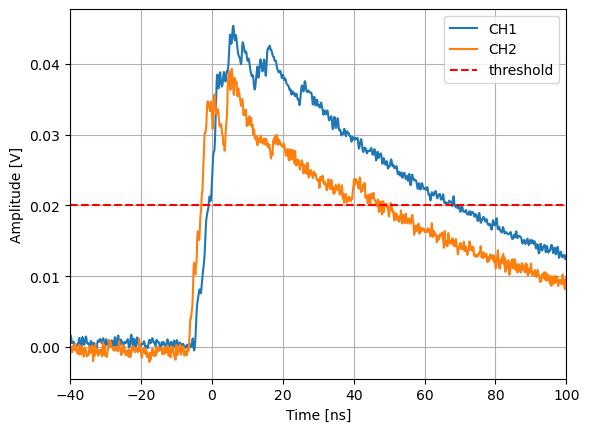

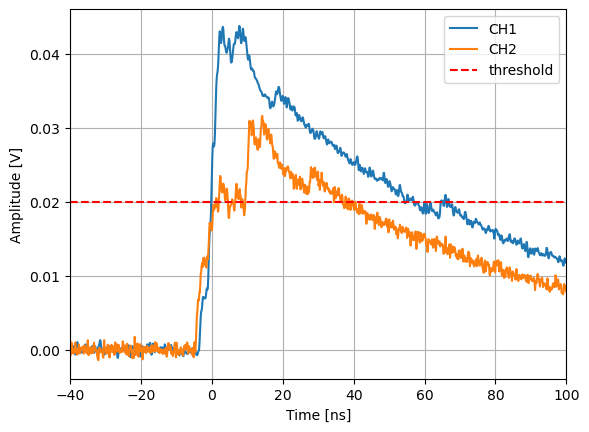

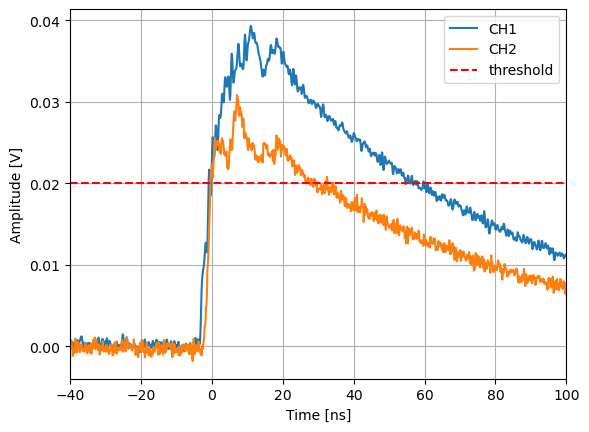

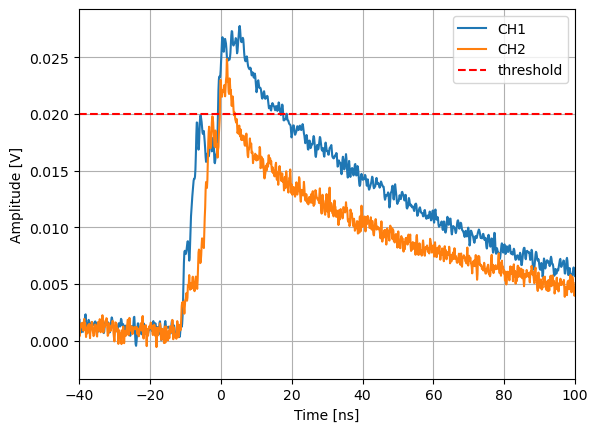

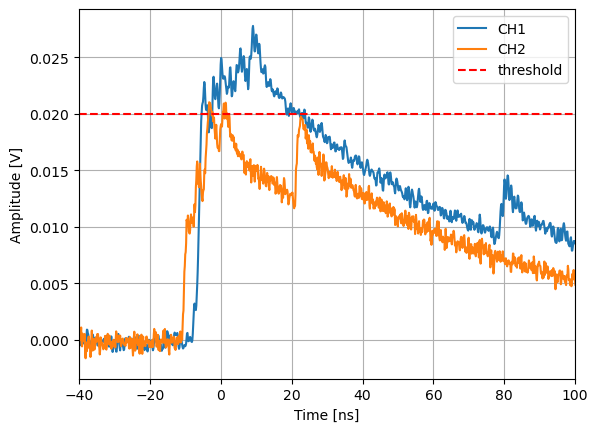

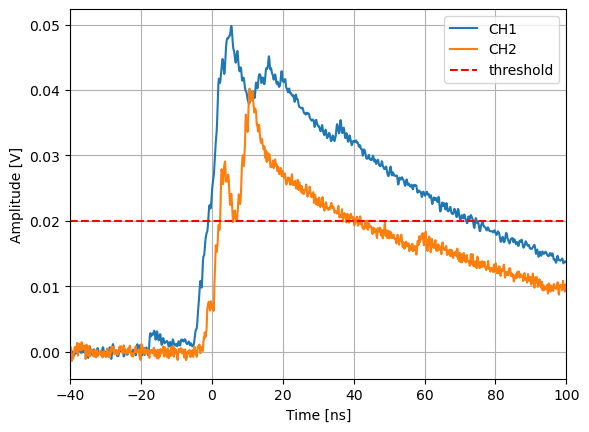

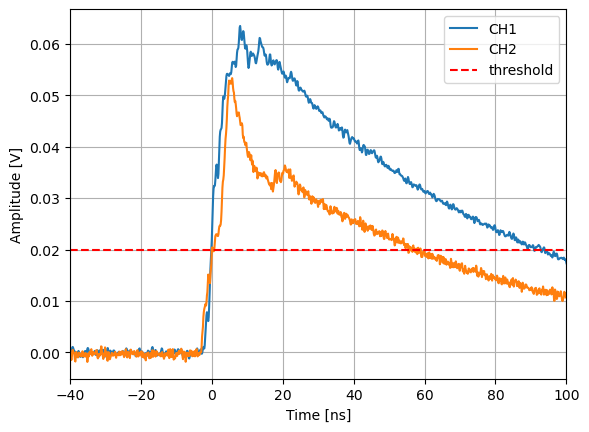

In [185]:
for i in range(100):
    
    if max(-data_save[2][i])>0.02:
        # CFD trigger
        plot(time_series, -data_save[1][i],label="CH1")
        plot(time_series, -data_save[2][i],label="CH2")
        axhline(0.02, linestyle="--", color="r", label="threshold")
        xlim(-40,100)
        xlabel("Time [ns]")
        ylabel("Amplitude [V]")
        grid()
        legend()
        show()

In [170]:
triggers_ch2 = []
triggers_ch1_cfd = []
triggers_ch2_cfd = []
amplitude_ch1 = []
amplitude_ch2 = []
for i in tqdm(range(len(data_save[2]))):
    
    # Edge trigger:
    trigger_time = (np.argmax( data_save[2][i]<-0.02)-2048)*(time_series[1]-time_series[0])
    triggers_ch2.append(trigger_time)
    amplitude_ch1.append(min(data_save[1][i]))
    amplitude_ch2.append(min(data_save[2][i]))
    
    
    # CFD trigger
    trace = data_save[2][i]
    trace-=np.mean(trace[:1600])
    trace = -trace
    leading_edges = constant_fraction_discriminator(trace, 0, 0.02, 0.5, gauss_filter=16)
    if len(leading_edges)>0:
        triggers_ch2_cfd.append((leading_edges[0][1]-2048)*(time_series[1]-time_series[0]))
    else:
        triggers_ch2_cfd.append(-999)
        
        
    # CFD trigger
    trace = data_save[1][i]
    trace-=np.mean(trace[:1600])
    trace = -trace
    leading_edges = constant_fraction_discriminator(trace, 0, 0.02, 0.5, gauss_filter=16)
    if len(leading_edges)>0:
        triggers_ch1_cfd.append((leading_edges[0][1]-2048)*(time_series[1]-time_series[0]))
    else:
        triggers_ch1_cfd.append(-999)        
    
    
triggers_ch2=np.array(triggers_ch2)    
triggers_ch1_cfd=np.array(triggers_ch1_cfd)    
triggers_ch2_cfd=np.array(triggers_ch2_cfd)    
amplitude_ch1=np.array(amplitude_ch1)    
amplitude_ch2=np.array(amplitude_ch2)    

100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:13<00:00, 144.06it/s]


In [171]:
# hist(-amplitude_ch1/0.004, range=(0,30),bins=100, histtype="step", label="CH1");
# hist(-amplitude_ch2/0.004, range=(0,30),bins=100, histtype="step", label="CH2");
# legend()


(-10.0, 10.0)

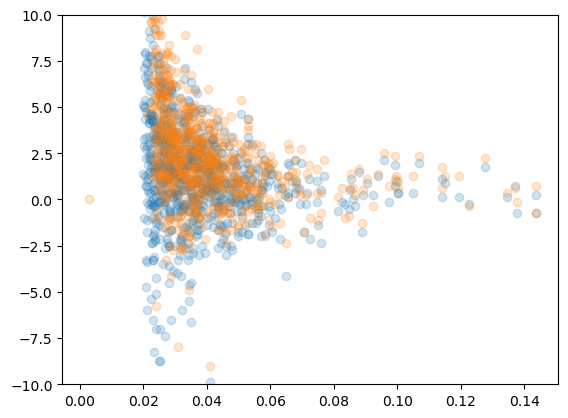

In [172]:
scatter(-amplitude_ch2,triggers_ch2,alpha=0.2)
scatter(-amplitude_ch2,triggers_ch2_cfd-triggers_ch1_cfd,alpha=0.2)
ylim(-10,10)

In [191]:
neh_ch1 = -amplitude_ch1/0.004
neh_ch2 = -amplitude_ch2/0.004

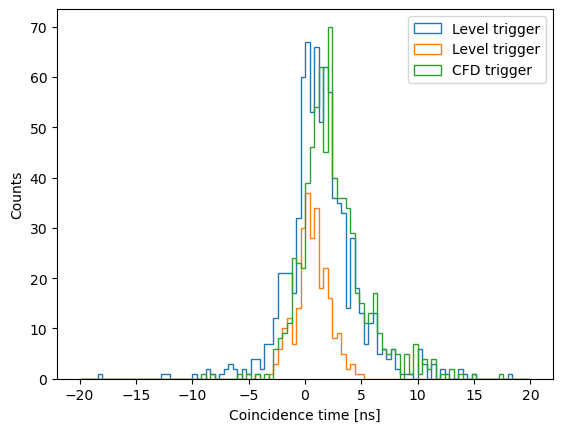

In [192]:
trigger_cfd = triggers_ch2_cfd-triggers_ch1_cfd

n1, ibins, _ = hist(triggers_ch2,bins=100,range=(-20,20),histtype="step", label="Level trigger");
n1, ibins, _ = hist(triggers_ch2[(neh_ch1>10)&(neh_ch2>10)],bins=100,range=(-20,20),histtype="step", label="Level trigger");
n2, ibins, _ = hist(trigger_cfd,bins=100,range=(-20,20),histtype="step", label="CFD trigger");

# bincenters2=0.5*(ibins[1:]+ibins[:-1])
# yerr=np.sqrt(n1);yerr[yerr==0]=1
# popt1,pcov = rt.fit_tg(bincenters2,n,yerr=yerr,function="gaus",fit_range=(-0.3,0.3))
# perr1 = np.sqrt(np.diag(pcov))
# print(popt1[2],'[ns]')
# plot(bincenters2, util.Utils.Gauss(bincenters2,*popt1),color="C1",linestyle=":",label=f"$\sigma$={popt1[2]:.3f} ns, mean={popt1[1]:.3f} ns")


np.std(triggers_ch2[abs(triggers_ch2)<10])/sqrt(2)
legend()
xlabel("Coincidence time [ns]")
ylabel("Counts")
legend()

In [194]:
np.std(triggers_ch2[abs(triggers_ch2-2)<5])/2, np.mean(amplitude_ch2[abs(triggers_ch2-2)<5])/0.004
np.std(triggers_ch2[(neh_ch1>10)&(neh_ch2>10)])/2

0.7331022825541003

# Analysis 2: Waveform difference

In [ ]:
from typing import List, Tuple
import scipy.ndimage

def constant_fraction_discriminator(waveform: List[float], baseline: float, threshold: float, fraction: float, gauss_filter = None) -> List[Tuple[float, int]]:
    """
    This function takes in a waveform, baseline, threshold, and fraction as input and returns a list of tuples containing
    the amplitude and sample number of the leading edge of each pulse.
    """
    leading_edges = []
    triggered = False
    
    if gauss_filter is not None:
        waveform = scipy.ndimage.gaussian_filter(waveform,sigma=gauss_filter,)
    
    for i in range(1, len(waveform)):
        if waveform[i] > baseline + threshold:
            if triggered:
                continue
                
            for j in range(i - 1, -1, -1):
                if waveform[j] < baseline + fraction * (waveform[i] - baseline):
                    leading_edges.append((waveform[i], i))
                    triggered=True
                    break
        else:
            triggered = False
    return leading_edges



# trace = data_save[1][0]
# trace-=np.mean(trace[:1600])
# trace = -trace
# trace/=15.8
# leading_edges = constant_fraction_discriminator(trace, 0, 0.02, 0.5, gauss_filter=4)
# plot(trace)
# print(leading_edges)
# axvline(leading_edges[0][1])

In [83]:
filenames = ["waveform_laser.joblib","waveform_scintillator.joblib","waveform_wlsf_laser.joblib","waveform_wlsf_scintillator.joblib"]
labels = ["Laser", "Scintillator", "WLS+Laser", "WLS+Scintillator"]

In [37]:
data_save=joblib.load(filenames[3])
time_series = data_save["metadata"]["time_series"]*1e9

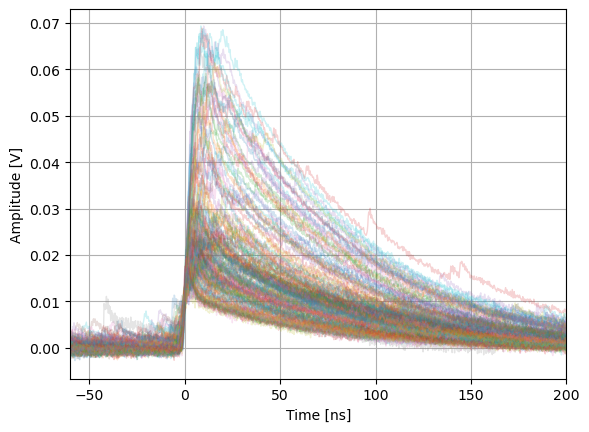

In [69]:
# for i in range(len(data_save[1])):
trace_original = []
trace_aligned = []
for i in range(len(data_save[1])):
    trace = data_save[1][i]
    trace-=np.mean(trace[:1600])
    trace = -trace
    trace/=15.8
    if (max(trace)>0.07) or  (max(trace)<0.01) or (min(trace)<-0.005):
        continue
        
    leading_edges = constant_fraction_discriminator(trace, 0, 0.01, 0.5, gauss_filter=4)
    trigger_offset = leading_edges[0][1]-2048
    trace_original.append(trace)
    trace = np.roll(trace, -trigger_offset)
    trace_aligned.append(trace)
    
    if i <200:
        plot(time_series, trace,alpha=0.2, linewidth=1)

xlim(-60,200)
xlabel("Time [ns]")
ylabel("Amplitude [V]")
grid()

Text(0.5, 0, 'Time [ns]')

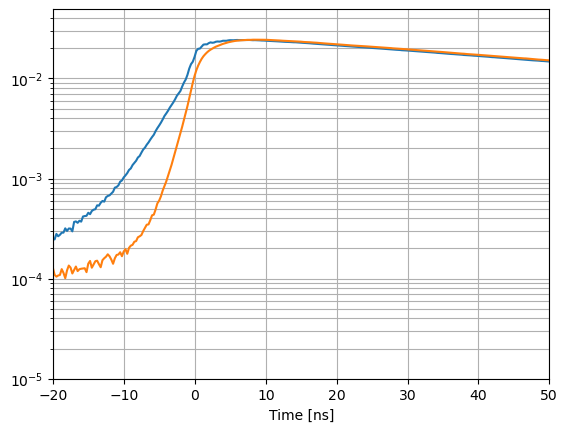

In [81]:
trace_original_avg = np.mean(trace_original, axis=0)
trace_aligned_avg = np.mean(trace_aligned, axis=0)
plot(time_series, trace_original_avg)
plot(time_series, trace_aligned_avg)

yscale("log")
xlim(-20,50)
ylim(1e-5,)
grid(which="both")
xlabel("Time [ns]")

In [82]:
trace_aligned_avg_all = []
for i in range(len(filenames)):
    data_save=joblib.load(filenames[i])
    time_series = data_save["metadata"]["time_series"]*1e9
    
    trace_aligned = []
    for i in range(len(data_save[1])):
        trace = data_save[1][i]
        trace-=np.mean(trace[:1600])
        trace = -trace
        trace/=15.8
        if (max(trace)>0.07) or  (max(trace)<0.01) or (min(trace)<-0.005):
            continue

        leading_edges = constant_fraction_discriminator(trace, 0, 0.01, 0.5, gauss_filter=4)
        trigger_offset = leading_edges[0][1]-2048
        trace = np.roll(trace, -trigger_offset)
        trace_aligned.append(trace)   
        
    trace_aligned_avg = np.mean(trace_aligned, axis=0)
    trace_aligned_avg_all.append(trace_aligned_avg)

Text(0, 0.5, 'Normalized amplitude')

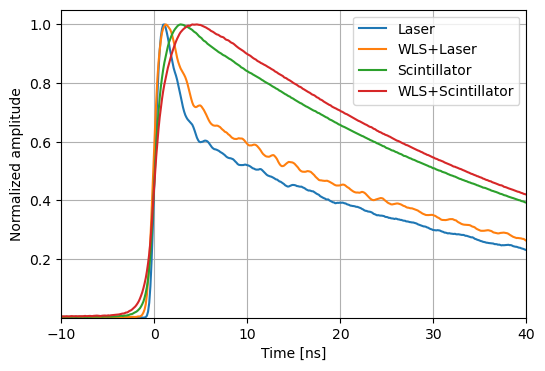

In [184]:
figure(figsize=(6,4))
for i in [0,2,1,3]:
    trace = trace_aligned_avg_all[i]
    plot(time_series, trace/max(trace),label=labels[i])
    
legend()

# yscale("log")
xlim(-10,40)
ylim(1e-5,)
grid(which="both")
xlabel("Time [ns]")
ylabel("Normalized amplitude")